# Machine Learning Model

Inicialmente foi ponderado a utilização de alguns modelos de Machine Learning:

- Linear Regression
- ~~KNN~~
- ~~Decision Tree~~
- SVM
- AdaBoost
- Random Forest

Porém após testes e análises, os modelos de KNN e Decision Tree foram **descartados**, pois não apresentaram bons resultados.

Para a resolução desse problema serão considerados os outros modelos, sendo que o modelo que apresentar o melhor resultado será utilizado.

## Imports

Foram utilizadas as seguintes bibliotecas:

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.model_selection import train_test_split, LearningCurveDisplay, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error as mae

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import joblib

from keras import models, layers

As métricas utilizadas para avaliação dos modelos foram:
- R2 Score
- Mean Absolute Error

E será utilizada em conjunto a validação cruzada com o KFold.

## Tratamento inicial

Observação dos dados

In [230]:
df = pd.read_pickle('../datasets/processed.pkl')
df.drop(columns = 'segundos_depois_meia_noite', inplace = True)
df.sample(5)

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
16491,2018-06-21 19:00:00,46.76,11.95,0.0,0.020004,96.89,100.0,Dia da Semana,Quinta-feira,Carga media
23069,2018-08-29 07:30:00,3.24,4.90,0.0,0.000000,55.16,100.0,Dia da Semana,Quarta-feira,Carga leve
24046,2018-09-08 11:45:00,40.25,14.47,0.0,0.020004,94.10,100.0,Final de Semana,Sabado,Carga maxima
34625,2018-12-27 16:30:00,63.22,29.63,0.0,0.029999,90.55,100.0,Dia da Semana,Quinta-feira,Carga media
9509,2018-04-10 01:30:00,3.56,4.18,0.0,0.000000,64.84,100.0,Dia da Semana,Terca-feira,Carga leve


In [231]:
df = pd.concat([df, pd.get_dummies(df.tipo_carga)], axis = 1).drop(columns = 'tipo_carga')

def rename_columns(column: str):
    column = column.replace(' ', '_')
    return column.lower()

for column_list in df.columns[-3:].tolist():
    df.rename(columns = {column_list: rename_columns(column_list)}, inplace = True)
del rename_columns

Após discussões obtidas durante as sessões de dúvidas, foi decidido que o tratamento inicial dos dados seria feito da seguinte forma:
- Agrupamento dos dados por dia, onde os numericos seriam as médias e os categóricos seriam a moda

In [232]:
df = df.groupby(df['data'].dt.date).agg({
    'consumo_energia': 'mean',
    'corrente_atrasada': 'mean',
    'corrente_principal': 'mean',
    'co2': 'mean',
    'potencia_atrasado': 'mean',
    'potencia_principal': 'mean',
    'estado_semana': lambda x: x.mode()[0],
    'dia_semana': lambda x: x.mode()[0],
    'carga_leve': 'sum',
    'carga_maxima': 'sum',
    'carga_media': 'sum'
}).reset_index()

df.data = pd.to_datetime(df.data)
for item in df.select_dtypes('object').columns:
    df[item] = df[item].astype('category')
    
df.estado_semana = LabelEncoder().fit_transform(df.estado_semana)

In [233]:
df.head()

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,carga_leve,carga_maxima,carga_media
0,2018-01-01,3.665208,1.735625,9.885000,0.000000,85.299375,57.076146,0,Segunda-feira,96,0,0
1,2018-01-02,41.150312,16.454479,3.063125,0.000000,84.207292,92.138125,0,Terca-feira,40,24,32
2,2018-01-03,37.094271,13.391562,2.766562,0.015937,86.100000,92.617292,0,Quarta-feira,40,24,32
3,2018-01-04,51.851250,21.449063,2.339271,0.022603,84.128125,93.423750,0,Quinta-feira,40,24,32
4,2018-01-05,48.785417,20.422917,2.689167,0.021250,84.063021,92.862813,0,Sexta-feira,40,24,32


In [234]:
aux = df.copy()
for item in aux.select_dtypes('category').columns:
    aux[item] = LabelEncoder().fit_transform(aux[item])

aux.corr(numeric_only=True).abs()

,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,carga_leve,carga_maxima,carga_media
consumo_energia,1.000000,0.937050,0.816783,0.990505,0.024184,0.857353,0.641788,0.373589,0.697431,0.697431,0.697431
corrente_atrasada,0.937050,1.000000,0.845748,0.932578,0.223848,0.839868,0.702574,0.386223,0.664797,0.664797,0.664797
corrente_principal,0.816783,0.845748,1.000000,0.821324,0.322724,0.947876,0.687508,0.418245,0.787385,0.787385,0.787385
co2,0.990505,0.932578,0.821324,1.000000,0.010454,0.856806,0.637512,0.364504,0.698431,0.698431,0.698431
potencia_atrasado,0.024184,0.223848,0.322724,0.010454,1.000000,0.174759,0.185159,0.098755,0.145692,0.145692,0.145692
potencia_principal,0.857353,0.839868,0.947876,0.856806,0.174759,1.000000,0.687059,0.435202,0.887250,0.887250,0.887250
estado_semana,0.641788,0.702574,0.687508,0.637512,0.185159,0.687059,1.000000,0.474785,0.506475,0.506475,0.506475
dia_semana,0.373589,0.386223,0.418245,0.364504,0.098755,0.435202,0.474785,1.000000,0.354839,0.354839,0.354839
carga_leve,0.697431,0.664797,0.787385,0.698431,0.145692,0.887250,0.506475,0.354839,1.000000,1.000000,1.000000
carga_maxima,0.697431,0.664797,0.787385,0.698431,0.145692,0.887250,0.506475,0.354839,1.000000,1.000000,1.000000


In [235]:
del aux
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                365 non-null    datetime64[ns]
 1   consumo_energia     365 non-null    float64       
 2   corrente_atrasada   365 non-null    float64       
 3   corrente_principal  365 non-null    float64       
 4   co2                 365 non-null    float32       
 5   potencia_atrasado   365 non-null    float64       
 6   potencia_principal  365 non-null    float64       
 7   estado_semana       365 non-null    int64         
 8   dia_semana          365 non-null    category      
 9   carga_leve          365 non-null    int64         
 10  carga_maxima        365 non-null    int64         
 11  carga_media         365 non-null    int64         
dtypes: category(1), datetime64[ns](1), float32(1), float64(5), int64(4)
memory usage: 30.8 KB


## Testes e experimentações com os dados e modelos

In [236]:
features = df.drop(columns = 'consumo_energia')
target = df.consumo_energia

Temos algumas alternativas para selecionar os dados que serão utilizados no modelo:
- Utilizar todos os dados disponíveis;
- Remover os dados com correlação baixa/alta com a variável alvo;
- Remover os dados com correlação alta entre si.

Foram realizados alguns testes relacionados a essas alternativas, e os resultados foram os seguintes:
- Foi feito alguns testes com todos os dados disponíveis, porém os resultados não foram satisfatórios;
- A variável Co2 possui uma correlação extremamente alta com a variável alvo, porém o seu uso tende a overfitting, então foi decidido que ela não seria utilizada. Além disso essa variável não estará disponível no momento da predição;
- Foram realizados alguns testes removendo as variáveis com correlação alta entre si, demonstrando resultados satisfatórios.

In [237]:
# Assim como previsto no notebook de EDA, as variáveis 'co2' e 'potencia_principal', serão removidas do conjunto de features.
features.drop(columns = ['data', 'co2', 'potencia_principal'], inplace = True)

In [238]:
# Para facilitar a criação do conjunto de treino e teste foi criada essa função.
def create_train(features=features, target=target):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 777)
    return x_train, x_test, y_train, y_test

In [239]:
x_train, x_test, y_train, y_test = create_train(features, target)

Para facilitar a criação do pipeline, foi desenvolvida essa função, que além de retornar o pipeline completo, possui a opção de não realizar o escalonamento dos dados, pois alguns modelos não necessitam dessa etapa.

In [240]:
def create_model(features: pd.DataFrame, model, scaler=True) -> Pipeline:    
    categorical = features.select_dtypes(include='category').columns.to_list()
    cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    
    transformers = [('cat', cat_transformer, categorical)]
    
    if scaler:
        numerical = features.select_dtypes(include='number').columns.to_list()
        num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        transformers.insert(0, ('num', num_transformer, numerical))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    steps = [('preprocessor', preprocessor), ("model", model)]
    
    return Pipeline(steps=steps)

Para análise das features foi utilizado o método de correlação de Pearson, e foi observado como os treinos e testes se comportam ao utilizar as features com maior correlação com a variável alvo, com o objetivo de encontrar um ponto de equilíbrio entre a quantidade de features e a acurácia do modelo.

In [241]:
def curve_of_feature(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, var: list, model, tol=.8) -> tuple:
    scaler = StandardScaler()
    score = { 'Error_train': [], 'Error_test': [] }
    
    higher_in_train = [0, 0]
    higher_in_test = [0, 0]
    
    for i in range(1, features.shape[1]+1):
        
        x_train_temp, x_test_temp = x_train[var[:i]], x_test[var[:i]]
        
        categorical = x_train_temp.select_dtypes(include='category').columns.to_list()
        x_train_temp = pd.get_dummies(x_train_temp, columns=categorical, drop_first=True)
        x_test_temp = pd.get_dummies(x_test_temp, columns=categorical, drop_first=True)
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        new_model = model
        new_model.fit(x_train_temp, y_train)
        y_pred_train = new_model.predict(x_train_temp)
        y_pred_test = new_model.predict(x_test_temp)
        
        error_train, error_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
        
        if i == 1: best_diff = [abs(error_train - error_test), i]
        elif error_test > tol or error_train > tol: 
            if abs(error_train - error_test) < best_diff[0]: best_diff = [abs(error_train - error_test), i] 
        if error_train > higher_in_train[0]: higher_in_train = [error_train, i]
        if error_test > higher_in_test[0]: higher_in_test = [error_test, i]
        
        score['Error_train'].append(error_train); score['Error_test'].append(error_test)
    
    return pd.DataFrame(score), higher_in_train, higher_in_test, best_diff

def plot_curve_of_features(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, corr_in_order, model_list, higher=True):
    fig = plt.figure(figsize=(16, 8))
    i = 0
    for name, model in model_list.items():
        curve, higher_in_train, higher_in_test, best_diff = curve_of_feature(x_train, x_test, y_train, y_test, corr_in_order, model)
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_title(name)
        x = np.arange(1, curve.shape[0]+1)
        sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
        ax.scatter(higher_in_train[1], higher_in_train[0], color='r', marker='x', s=100)
        sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
        ax.scatter(higher_in_test[1], higher_in_test[0], color='g', marker='x', s=100)
        plt.axvline(x=best_diff[1], color='b', linestyle='--')
        ax.set_xticks(x)
        ax.set_ylabel('R2 Score')
        if higher: ax.set_xlabel('Number of features with highest correlation')
        else: ax.set_xlabel('Number of features with lower correlation')
        ax.legend()
        i+=1
    fig.tight_layout()

Utilizamos alguns gráficos para melhor visualização dos resultados:

In [242]:
features_test = features.copy()
for item in features_test.select_dtypes('category').columns:
    features_test[item] = LabelEncoder().fit_transform(features_test[item])

corr_strong = pd.concat([features_test, target], axis = 1).corr(numeric_only=True).abs().consumo_energia.sort_values(ascending=False)[1:].index.tolist()

del features_test

# corr_weak = corr_strong[::-1]

A partir dos dados tratados, foram realizados testes com os seguintes modelos:
- Regressão Linear
- SVR
- Ada Boost
- Random Forest

In [243]:
model_list = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=777),
    'Random Forest Regressor': RandomForestRegressor(random_state=777, n_jobs=-1),
}

> Foi desconsiderada a análise das variáveis de maneira crescente, pois o resultado não foi satisfatório.

In [244]:
# plot_curve_of_features(x_train, x_test, y_train, y_test, corr_weak, model_list, higher=False)
# plt.show()

Estes gráficos demonstram a acurácia dos modelos em relação a quantidade de features utilizadas:
- Estão marcadados os pontos de maior acurácia de cada modelo, para treino e teste.
- A linha tracejada representa o menor intervalo de acurácia entre treino e teste.

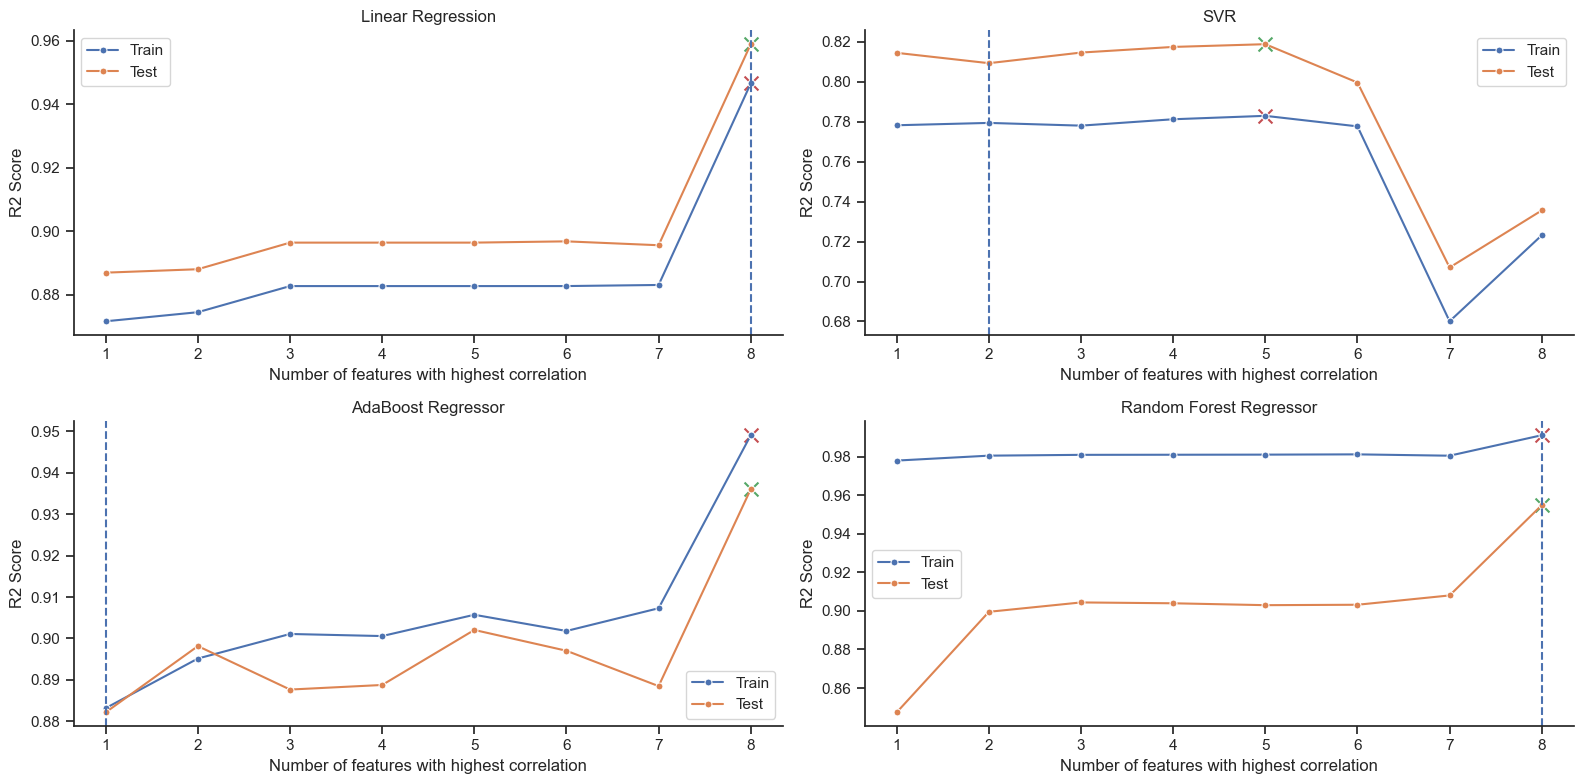

In [245]:
plot_curve_of_features(x_train, x_test, y_train, y_test, corr_strong, model_list)
plt.show()

Como cada modelo possui uma quantidade de features que apresenta o melhor resultado, foi decidido customizar a quantidade de features utilizadas em cada modelo, de acordo com o gráfico acima.

In [246]:
features_list = {
    'Linear Regression': features.iloc[:, :8].copy(),
    'SVR': features.iloc[:, :6].copy(),
    'AdaBoost Regressor': features.iloc[:, :8].copy(),
    'Random Forest Regressor': features.iloc[:, :8].copy()
}

In [247]:
def drop_of_features(features, target, model):
    score = { 'Error_train': [], 'Error_test': [] }
    features = features.copy()
    for feat in features.columns:
        features[feat] = LabelEncoder().fit_transform(features[feat])

    x_train, x_test, y_train, y_test = create_train(features, target)
    
    for feat in features.columns:
        x_train_temp, x_test_temp = x_train.drop(columns=feat), x_test.drop(columns=feat)
        
        scaler = StandardScaler()
        x_train_temp = scaler.fit_transform(x_train_temp)
        x_test_temp = scaler.transform(x_test_temp)
        
        model.fit(x_train_temp, y_train)
        y_pred_train = model.predict(x_train_temp)
        y_pred_test = model.predict(x_test_temp)
        
        score['Error_train'].append(mae(y_train, y_pred_train))
        score['Error_test'].append(mae(y_test, y_pred_test))
        
    return features.columns, pd.DataFrame(score)

def plot_drop_of_features(features, target, model_list):
    fig = plt.figure(figsize=(16, 8))
    i = 0
    for name, model in model_list.items():
        features_to_remove, curve = drop_of_features(features_list[name], target, model)
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_title(name)
        x = np.arange(1, curve.shape[0]+1)
        sns.lineplot(data=curve, x=x, y='Error_train', marker= '.', markersize=10, ax=ax, label='Train')
        sns.lineplot(data=curve, x=x, y='Error_test', marker= '.', markersize=10, ax=ax, label='Test')
        ax.set_xlabel('Features')
        ax.set_ylabel('MAE Score')
        ax.set_xticks(x)
        ax.set_xticklabels(features_to_remove.to_list(), rotation=45)
        ax.legend()
        i+=1
    fig.tight_layout()

Após a customização, foi realizada mais uma rodada de testes relacionadas a seleção de features, desta vez dropando as colunas restantes e observando o resultado.

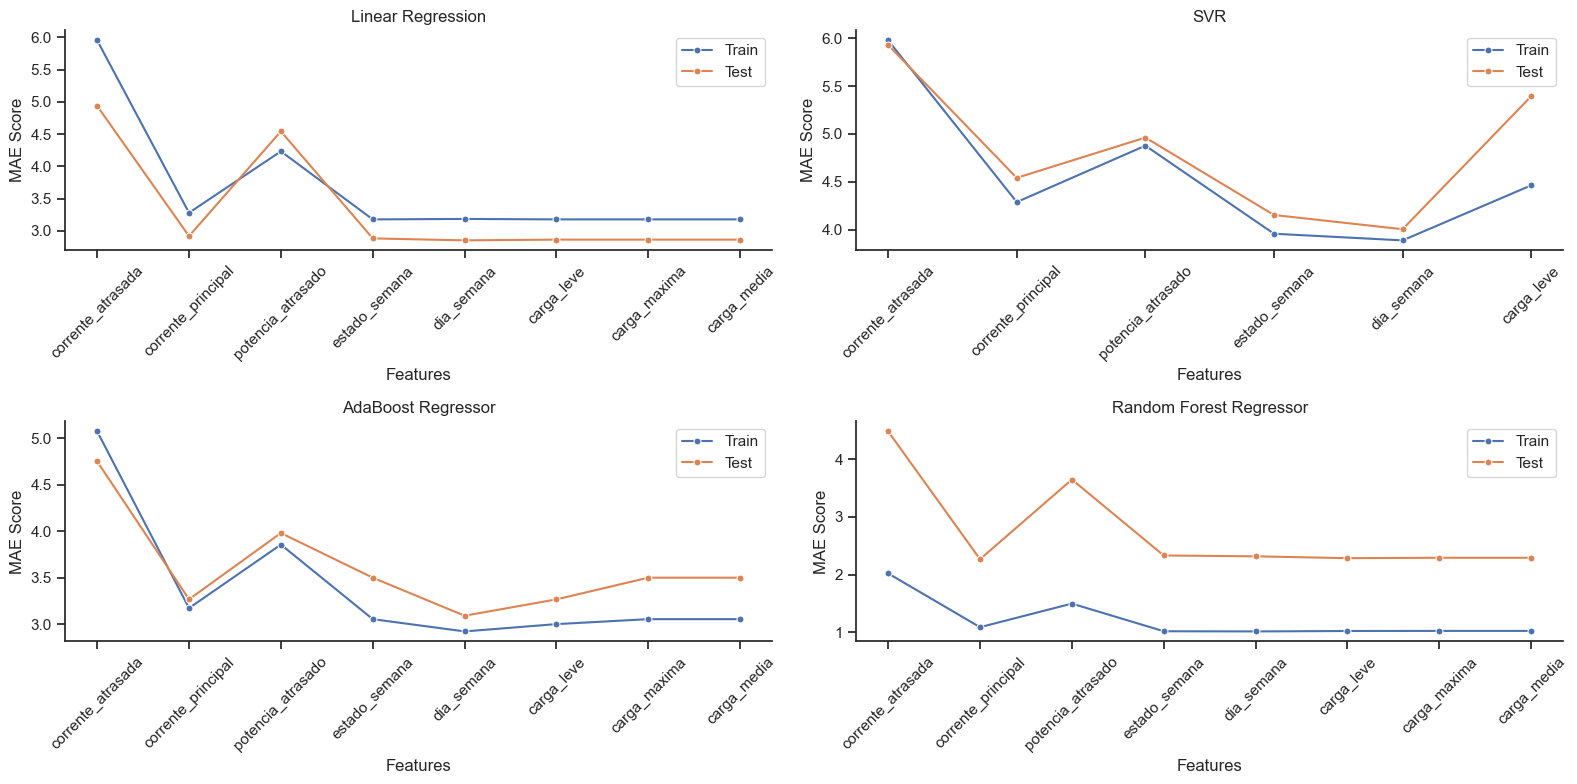

In [248]:
plot_drop_of_features(features, target, model_list)
plt.show()

Após a análise dos resultados, foi decidido eliminar mais uma feature de cada modelo para prosseguirmos com os testes.

In [249]:
features_list['Linear Regression'].drop(columns='potencia_atrasado', inplace=True)
features_list['SVR'].drop(columns='dia_semana', inplace=True)
features_list['AdaBoost Regressor'].drop(columns='dia_semana', inplace=True)
features_list['Random Forest Regressor'].drop(columns='potencia_atrasado', inplace=True)

### Algumas funções para facilitar a análise dos resultados

In [250]:
def create_learning_curves(model_list: dict, features: dict, target: pd.Series, n_row = 2, n_col = 2, cv = 5, scoring = 'r2') -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, (algorithm, model_) in enumerate(model_list.items()):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        plt.title(f"{algorithm}", fontsize='large', fontweight='bold')
        plt.grid(visible=True, color='black', linewidth=.25)
        plt.xlabel("Number of Samples")
        LearningCurveDisplay.from_estimator(model_, features[algorithm], target, score_type='both', ax=ax, cv=cv, scoring=scoring, n_jobs=-1, random_state=777)
    fig.tight_layout()

In [251]:
def create_scores(model_list: dict, features: dict, target: pd.Series) -> pd.DataFrame:
    scores = { 'Algorithm': [], 'Type': [], 'R2': [], 'Mean Absolute Error': [] }
    
    for algorithm, the_model in model_list.items():
        x_train, x_test, y_train, y_test = create_train(features[algorithm], target)
        
        for item in ['Train', 'Test']:
            model = the_model
            model.fit(x_train, y_train)
            
            if item == 'Train':
                pred_y = model.predict(x_train)
                scores['Type'].append('Train')
                pred = y_train
            else:
                pred_y = model.predict(x_test)
                scores['Type'].append('Test')
                pred = y_test
                
            scores['Algorithm'].append(algorithm)
            scores['R2'].append( round( r2_score(pred, pred_y), 2) )
            scores['Mean Absolute Error'].append( round( mae(pred, pred_y), 2) )

    return pd.DataFrame(scores)

In [252]:
def create_plot(results: pd.DataFrame, n_rows = 2, n_cols = 2, rot=45) -> None:
    fig = plt.figure(figsize=(16, 10))
    for i, title in enumerate(results.columns[2:]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.barplot(data=results, x='Algorithm', y=title, hue='Type', palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
        ax.grid(visible=True, color='black', linewidth=.25)
    fig.tight_layout()

In [253]:
def cross_validation(model, model_name: str, features: pd.DataFrame, target: pd.Series, cv=5) -> pd.DataFrame:
    kf = KFold(n_splits=cv)
    scores = { 'model': model_name, 'train_score': [], 'test_score': [], 'train_mae': [], 'test_mae': [], }

    for train_index, test_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        test_x, test_y = features.iloc[test_index], target.iloc[test_index]
        
        new_model = model
        new_model.fit(train_x, train_y)

        pred_train_y = new_model.predict(train_x)
        pred_test_y = new_model.predict(test_x)

        scores['train_score'].append( r2_score(train_y, pred_train_y) )
        scores['test_score'].append( r2_score(test_y, pred_test_y) )
        scores['train_mae'].append( mae(train_y, pred_train_y) )
        scores['test_mae'].append( mae(test_y, pred_test_y) )
    
    return pd.DataFrame(scores)

In [254]:
def plot_validation_curve(results: list, title: list, type: str, n_row=2, n_col=2) -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, item in enumerate(results):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        x = np.arange(item.shape[0])
        
        if type == 'r2': metric_train, metric_test = 'train_score', 'test_score'
        else: metric_train, metric_test = 'train_mae', 'test_mae'
        
        if item[metric_train].max() < item[metric_test].max(): max = item[metric_test].max()
        else: max = item[metric_train].max()
        if item[metric_train].min() > item[metric_test].min(): min = item[metric_test].min()
        else: min = item[metric_train].min()
            
        min, max = round(min, 1), round(max, 1)
        
        sns.lineplot(data=item, x=x, y=metric_train, label='Training Scores', marker= 'o', markersize=5, ax=ax)
        sns.lineplot(data=item, x=x, y=metric_test, label='Testing Scores', marker= 'o', markersize=5, ax=ax)

        if type == 'r2': ax.set(ylabel='R2 Score')
        else: ax.set(ylabel='MAE Score')
        
        ax.grid(visible=True, color='black', linewidth=.5)
        ax.set_title(title[i])
        ax.set_ylim(min-0.1, max+0.1)
        
    fig.tight_layout()

## Testes de modelos com as features selecionadas

In [255]:
model_list = {
    'Linear Regression': create_model(features_list['Linear Regression'], LinearRegression()),
    'SVR': create_model(features_list['SVR'], SVR()),
    'AdaBoost Regressor': create_model(features_list['AdaBoost Regressor'], AdaBoostRegressor(random_state=777)),
    'Random Forest Regressor': create_model(features_list['Random Forest Regressor'], RandomForestRegressor(random_state=777, n_jobs=-1)),
}

Ao observar a curva de aprendizado dos modelos, observa-se que:
- Linear Regression: Apesar de ser um modelo simples, ele apresenta um resultado satisfatório, e não apresenta overfitting;
- SVR: Apresenta a melhor generalização entre os modelos;
- AdaBoost: Ao final da curva o treino e teste tendem a estabilizar, porém o resultado não é satisfatório;
- Random Forest: O modelo apresenta overfitting.

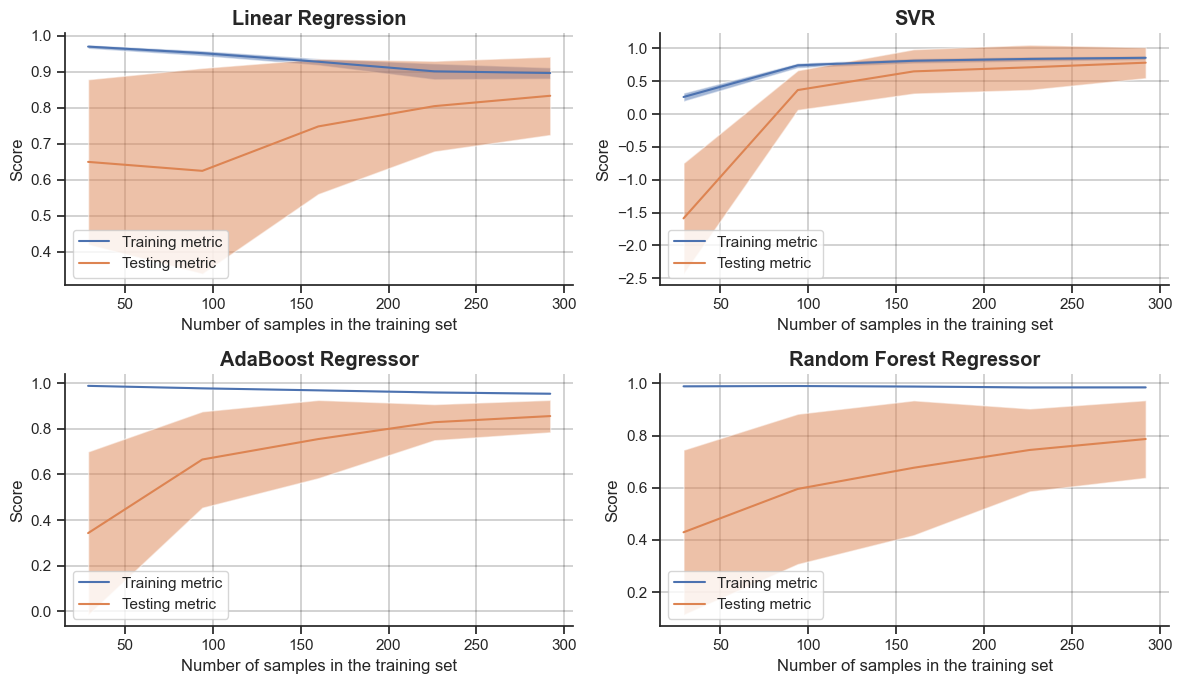

In [256]:
create_learning_curves(model_list, features_list, target)
plt.show()

Observando esse comparativo utilizando as métricas R2 e MAE:
- Linear Regression: Apesar de ser um modelo mais simples apresenta resultados satisfatórios, porém não é o melhor;
- SVR: Apesar de generalizar melhor o problema, não apresenta um resultado satisfatório;
- AdaBoost: Mantém um resultado satisfatório e constante;
- Random Forest: Como visto acima, o modelo apresenta overfitting, apesar de apresentar os melhores resultados.

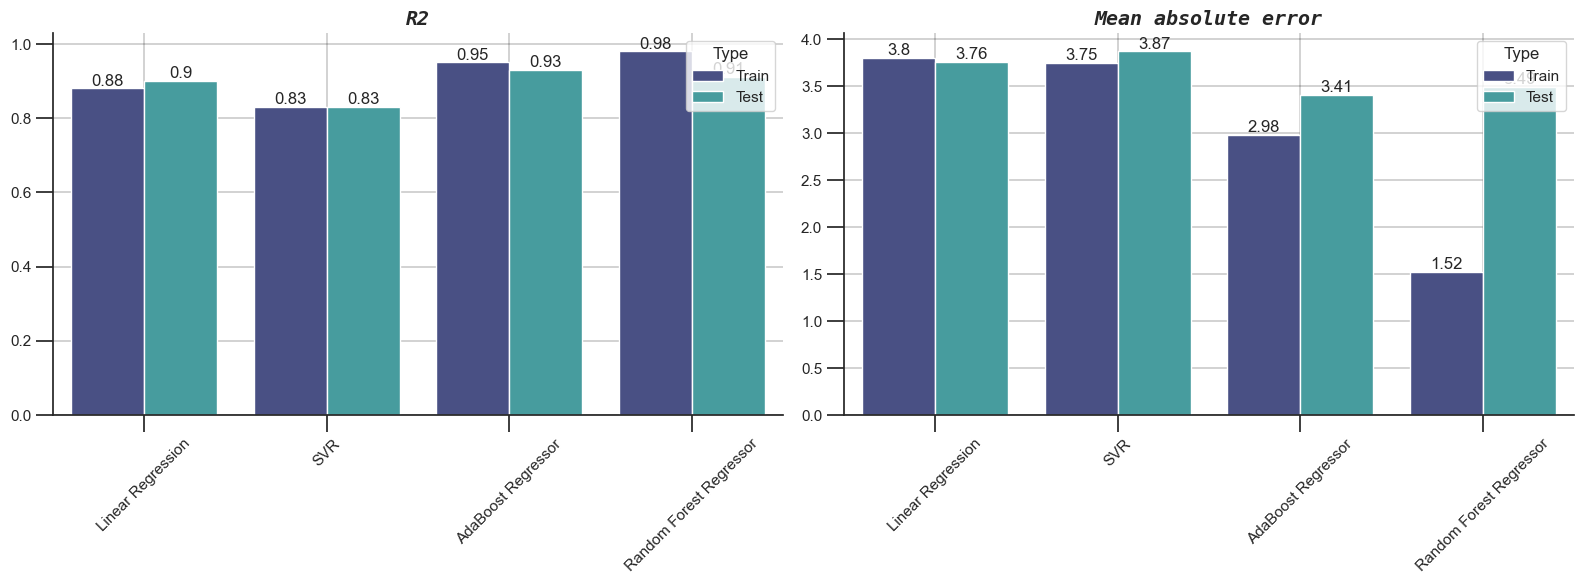

In [257]:
scores = create_scores(model_list, features_list, target)

create_plot(scores)
plt.show()

Agora vamos observar mais detalhadamente como o modelo se comporta com uma validação cruzada com 5 folds.

In [258]:
model_results = [cross_validation(model, model_name, features_list[model_name], target, cv=5) for model_name, model in model_list.items()]

Ao comparar o rendimento dos modelos, com as duas métricas, observa-se que:
- O SVR apresenta o melhor resultado.

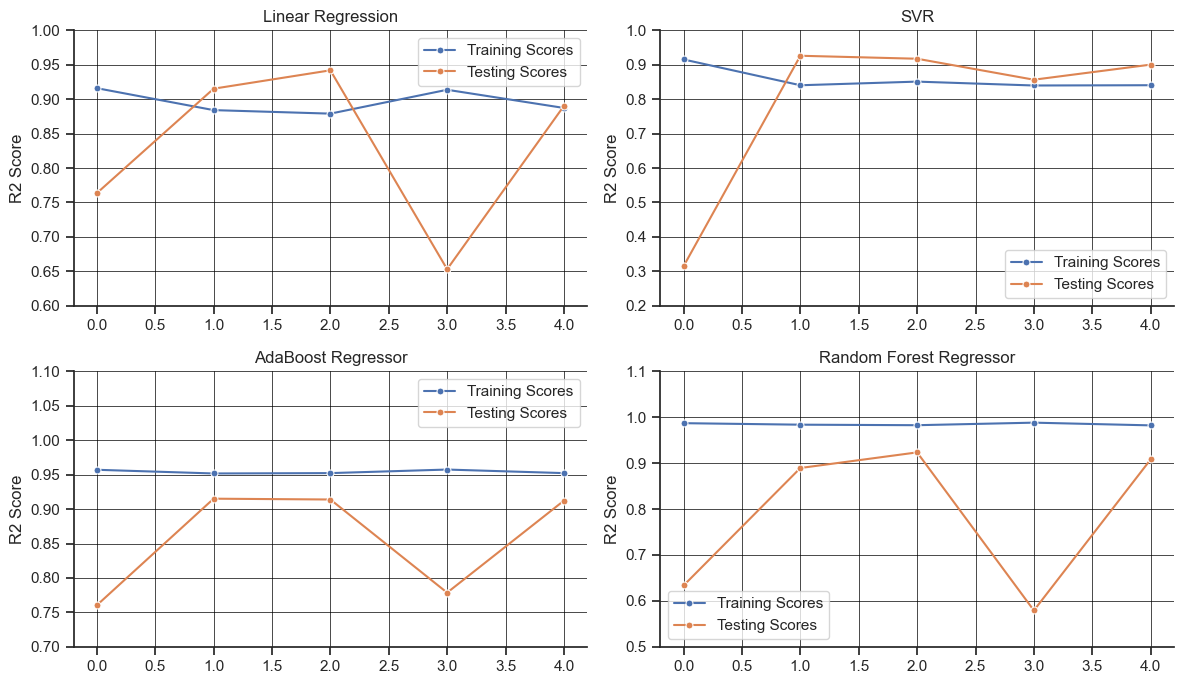

In [259]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

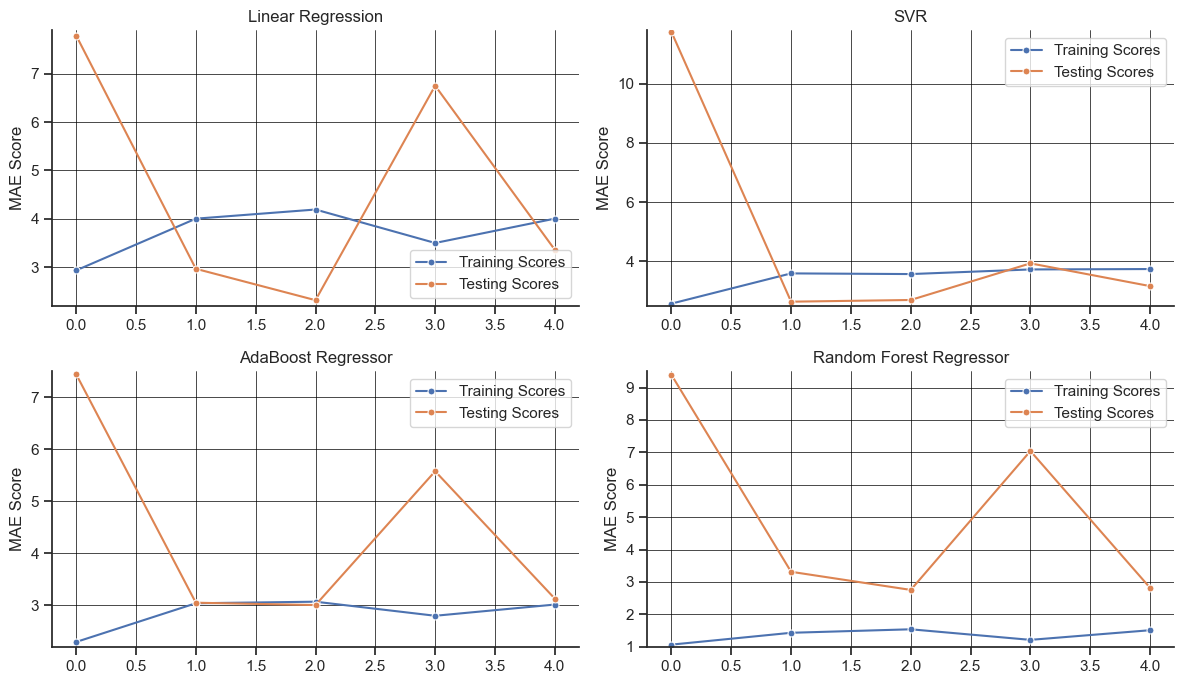

In [260]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

## Tunagem de hiperparâmetros

Não foi possível utilizar o métodos de Search com as variáveis categóricas do Pipeline, então foi decidido modificar essas features manualmente para realizar a tunagem de hiperparâmetros.

In [261]:
features_grid = features_list.copy()

for name, feature in features_grid.items():
    numerical = feature.select_dtypes(include='number').columns
    categorical = feature.select_dtypes(include='category').columns

    feature[numerical] = StandardScaler().fit_transform(feature[numerical])
    feature = pd.get_dummies(feature, columns=categorical, drop_first=True)
    features_grid[name] = feature

In [262]:
param_grid = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'positive': [True, False]
}

grid = GridSearchCV(LinearRegression(), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid.fit(features_grid['Linear Regression'], target)
grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'copy_X': True, 'fit_intercept': True, 'positive': True}

In [263]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0, 4.0, 5.0],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]
}

grid = GridSearchCV(SVR(), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid.fit(features_grid['SVR'], target)
grid.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


{'C': 3.0, 'degree': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}

In [264]:
param_grid = {
    'n_estimators': np.arange(5, 51, 5),
    'learning_rate': np.arange(0.1, 1.1, 0.1),
    'loss': ['linear', 'square', 'exponential']
}

grid = GridSearchCV(AdaBoostRegressor(random_state=777), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid.fit(features_grid['AdaBoost Regressor'], target)
grid.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


{'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 35}

In [265]:
param_grid = {
    'max_depth': np.arange(1, 10),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': np.arange(15, 100, 15)
}

grid = GridSearchCV(RandomForestRegressor(random_state=777), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid.fit(features_grid['Random Forest Regressor'], target)
grid.best_params_

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 15}

In [266]:
del features_grid

## Testes de modelos tunados

In [342]:
model_list = {
    'Linear Regression': create_model(features_list['Linear Regression'], LinearRegression(copy_X=True, fit_intercept=True, positive=True)),
    'SVR': create_model(features_list['SVR'], SVR(C=3.0, degree=1, epsilon=0.2, gamma='scale', kernel='poly')),
    'AdaBoost Regressor': create_model(features_list['AdaBoost Regressor'], AdaBoostRegressor(learning_rate=1, loss='exponential', n_estimators=35, random_state=777)),
    'Random Forest Regressor': create_model(features_list['Random Forest Regressor'], RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=3, min_samples_split=8, n_estimators=15, random_state=777, n_jobs=-1)),
}

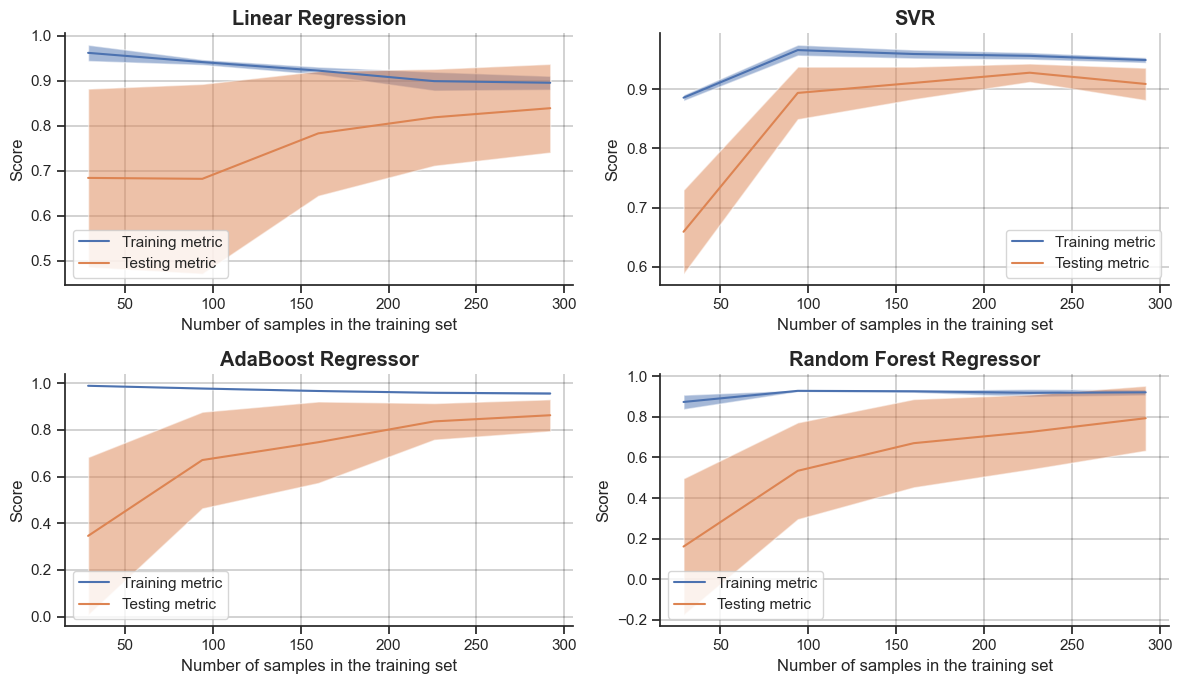

In [343]:
create_learning_curves(model_list, features_list, target)
plt.show()

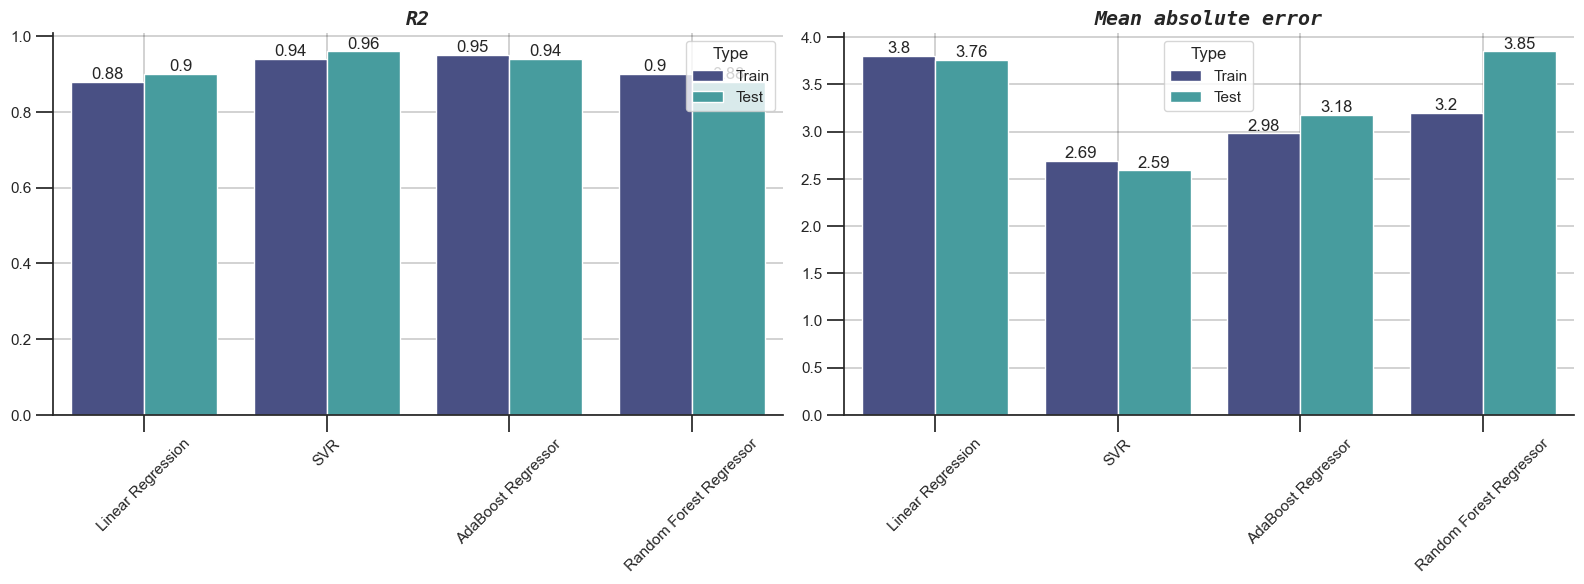

In [344]:
scores = create_scores(model_list, features_list, target)

create_plot(scores)
plt.show()

In [345]:
model_results = [cross_validation(model, model_name, features_list[model_name], target, cv=5) for model_name, model in model_list.items()]

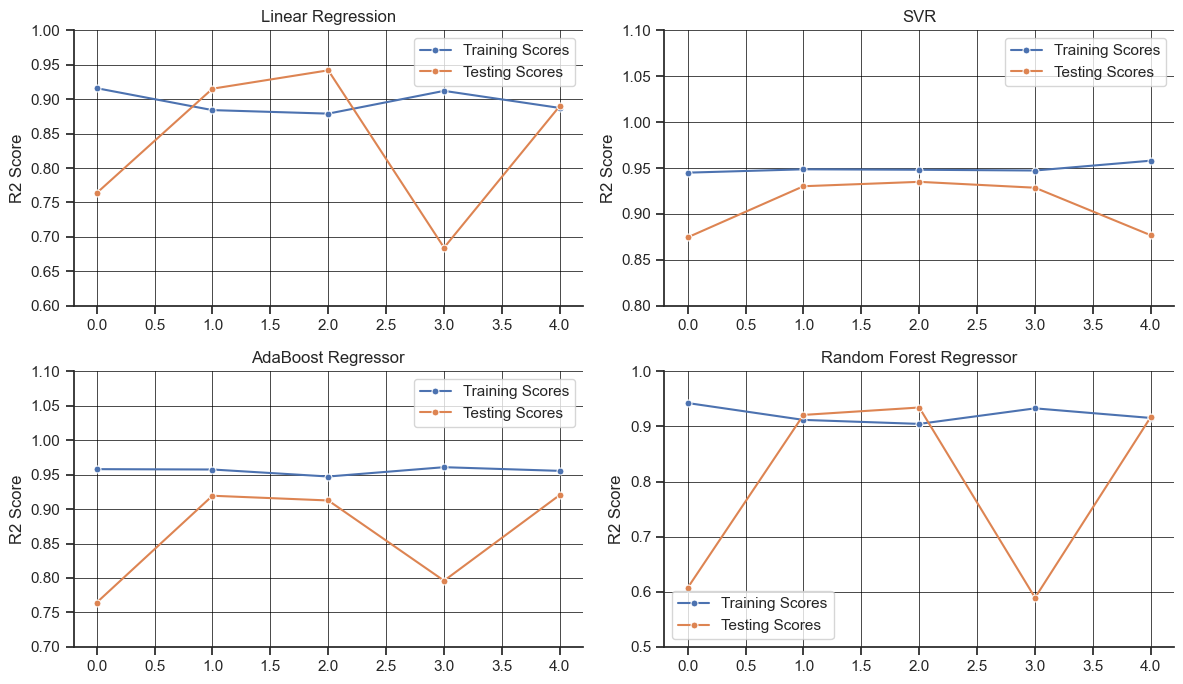

In [346]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

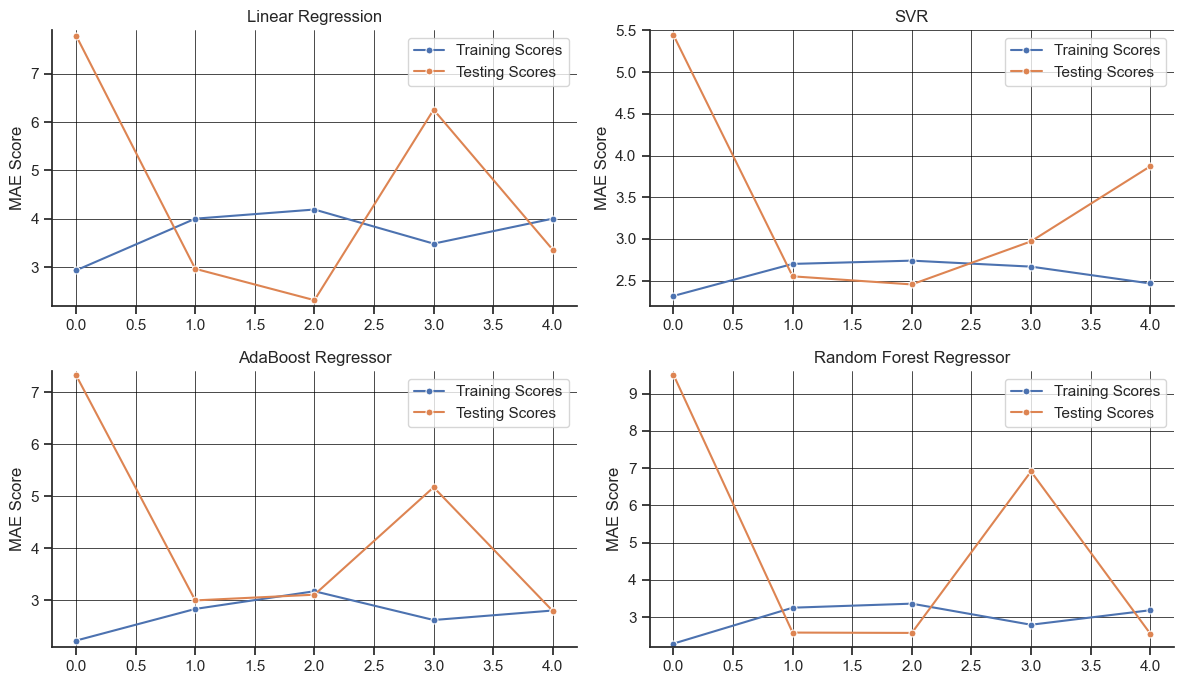

In [347]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

## Análise dos resultados

### Learning Curve

<img src="../outputs/Learning_Curve_0.png" alt="Learning_Curve_Before" width="800"/>
<img src="../outputs/Learning_Curve_1.png" alt="Learning_Curve_After" width="800"/>

### Scores

<img src="../outputs/Scores_0.png" alt="Scores_Before" width="1000"/>
<img src="../outputs/Scores_1.png" alt="Scores_After" width="1000"/>

### KFold (R2)

<img src="../outputs/KFold_R2_0.png" alt="KFold_R2_Before" width="1000"/>
<img src="../outputs/KFold_R2_1.png" alt="KFold_R2_After" width="1000"/>

### KFold (MAE)

<img src="../outputs/KFold_MAE_0.png" alt="KFold_MAE_Before" width="1000"/>
<img src="../outputs/KFold_MAE_1.png" alt="KFold_MAE_After" width="1000"/>

## Redes neurais

Também foi testado o modelo de redes neurais.

In [350]:
features_neural = df.drop(columns = ['data', 'consumo_energia'])

In [351]:
features_neural = pd.get_dummies(features_neural, drop_first=True)

x_train, x_test, y_train, y_test = create_train(features_neural, target)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Foi desenvolvido uma rede neural simples, com 3 camadas, sendo a primeira com 40 neurônios, a segunda com 20 neurônios e a terceira com 1 neurônio.

In [352]:
def create_network(len_input: int) -> models.Sequential:
    network = models.Sequential()
    network.add(layers.Dense(40, input_shape=(len_input, ), activation='relu'))
    network.add(layers.Dense(20))
    network.add(layers.Dense(1))
    network.compile(loss="mae", optimizer='Adam', metrics=["mse"])
    return network

model = create_network(features_neural.shape[1])

history = model.fit(x_train_scaled, y_train, epochs=10, verbose=0, batch_size=10, 
                    validation_data=(x_test_scaled, y_test), shuffle=True)
pred_y = model.predict(x_test_scaled)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(y_test, pred_y):}',)
print(f'Mean Absolute Error: {mae(y_test, pred_y):}')

4/4 [==============================] - 0s 620us/step
Algorithm: MLP
R2 score: 0.9573958373403093
Mean Absolute Error: 1.9940275866479582


Seus resultados foram melhores que os modelos de Machine Learning.

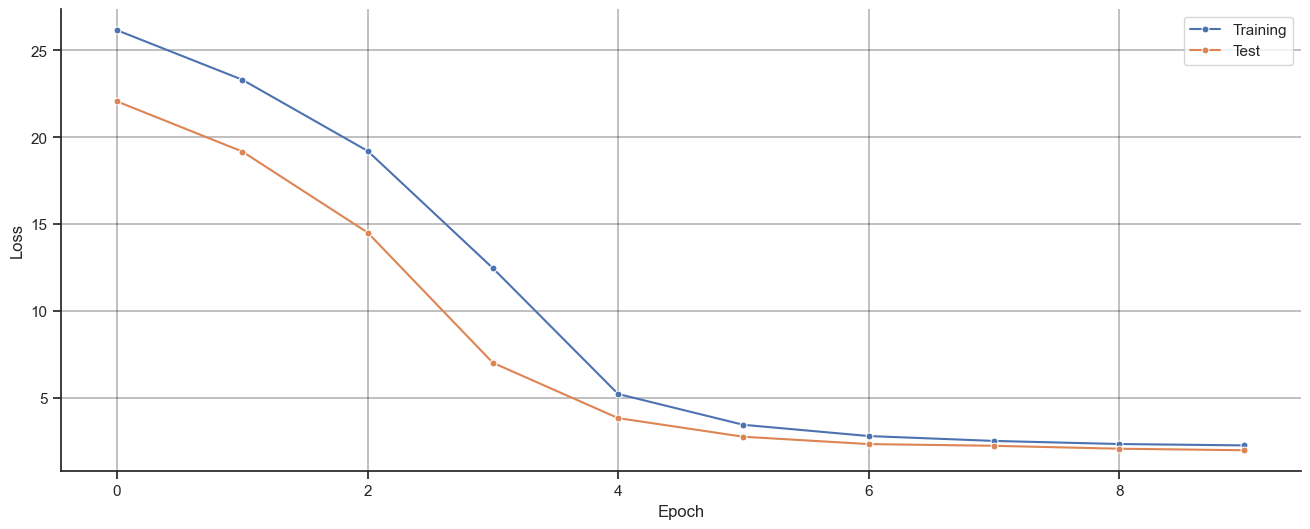

In [353]:
fig, ax = plt.subplots(figsize=(16, 6))

loss = pd.DataFrame({'training_loss': history.history["loss"], 'test_loss': history.history["val_loss"]})

epoch_count = np.arange(loss.shape[0])

sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test', marker= '.', markersize=10, ax=ax)
ax.legend()
ax.set(xlabel='Epoch', ylabel='Loss')
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()

## Exportando o modelo

In [354]:
final_model = create_model(features_list['SVR'], SVR(C=3.0, degree=1, epsilon=0.1, gamma='scale', kernel='poly'))

joblib.dump(final_model, '../models/final_model.pkl')

['../models/final_model.pkl']

## Conclusão

Dentre os modelos testados, o que apresentou o melhor resultado foi o SVR, porém o modelo de redes neurais apresentou um resultado bastante interessante.

Portanto, deve-se levar em consideração o custo de processamento de cada modelo, pois o modelo de redes neurais é mais custoso que o modelo de SVR.